<a href="https://colab.research.google.com/github/TomAmster/Data-Science/blob/master/SMOTE_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
!pip install shap

In [0]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split, cross_validate
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score, average_precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier as AdaB
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import shap
from sklearn.neighbors import NearestNeighbors

In [0]:
drive_dir = '/content/drive/Shared drives/DS Workshop/data/'
x_train_path = drive_dir + 'x_train_with_features'
X = pd.read_csv(x_train_path)

In [0]:
X.head()

,Unnamed: 0,bidder_id,outcome,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,...,zz,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
0,0,e8e4603ed284adbd252a7a601f9bffe09oq6f,0.0,False,0,1,0,0,8,1,1,4,4,7,3,8.000000,2.000000,2.666667,2.000000,1.142857,0.111111,1,0.285714,1,1.000000,1,1.0,1,0.333333,4.0,4.000000,4.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.000000,5.263158e+07,4.494737e+12,52631579.0,4.494737e+12,0.0,0.0,1.0,0.0,3.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,1.0,1.000000,38308.0,47885.0,31923.0,5065.0,5065.0,7.0,25.000000,37.500000,0.000000,37.500000
1,1,fdd836950d203286832a21b930b9f6b58ch7s,0.0,False,1,0,0,1,456,135,1,119,26,292,140,3.377778,3.831933,3.257143,17.538462,1.256198,0.241265,1,0.417808,1,0.991597,1,1.0,1,0.007143,1.0,1.059259,3.0,0.0,0.00,0.003145,0.0,0.0,0.0,0.0,0.0,...,0.0,1,95.0,169.0,0.370614,1.850974e+12,2.041296e+13,52631579.0,5.025026e+13,169.0,53.0,14.0,14.0,23.0,10.0,13.0,13.0,52.0,94.0,1.0,0.0,0.0,1.0,0.0,0.0,11.0,17.0,18.0,7.0,1.837500,4511.0,2404.0,2320.0,6.0,1.0,1.0,18.201754,45.833333,19.517544,16.447368
2,2,69333c66e55cdd6cabcc6ae64531fc33w20n4,0.0,False,0,1,0,0,2,2,1,1,1,1,1,1.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0,0.000000,1,1.000000,1,1.0,0,0.000000,1.0,1.000000,1.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.000000,1.598882e+12,4.422000e+12,947368421.0,9.473684e+08,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.000000,15322.0,11968.0,11621.0,319.5,128.0,92.0,0.000000,0.000000,100.000000,0.000000
3,3,31a301c70e897bf36276031abdf07ab6cs6z0,0.0,False,0,1,0,0,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0,0.000000,1,1.000000,1,1.0,1,1.000000,1.0,1.000000,1.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.000000,1.598882e+12,4.422000e+12,789473684.0,5.696500e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,15322.0,11968.0,11621.0,319.5,128.0,92.0,0.000000,0.000000,100.000000,0.000000
4,4,50791a0a98478b7f78f8d30acaa4683dxab5p,0.0,False,0,1,0,1,695,130,1,196,50,546,291,5.346154,3.545918,2.388316,13.900000,1.210801,0.292981,1,0.307692,1,0.969388,1,1.0,1,0.003436,1.0,1.253846,25.0,0.0,0.06,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0,189.0,196.0,0.282014,1.188183e+13,2.266448e+13,52631579.0,5.006458e+13,196.0,151.0,2.0,2.0,4.0,4.0,9.0,1.0,137.0,189.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,10.0,14.0,3.0,1.138889,2069.0,1376.0,1313.0,1.0,1.0,1.0,29.208633,35.683453,16.258993,18.848921


In [0]:
#drop bidders with 1 bid or less

bots = X[X['outcome'] == 1]
ind = bots[bots['bids_count'] <= 1].index
X.drop(labels=ind, axis=0, inplace=True)

In [0]:
X.shape

(2008, 266)

In [0]:
Y = X['outcome']
X.drop(labels=['outcome', 'bidder_id', 'Unnamed: 0'], axis=1, inplace=True)
X.head()

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,zz,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
0,False,0,1,0,0,8,1,1,4,4,7,3,8.000000,2.000000,2.666667,2.000000,1.142857,0.111111,1,0.285714,1,1.000000,1,1.0,1,0.333333,4.0,4.000000,4.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0,1.0,0.0,0.000000,5.263158e+07,4.494737e+12,52631579.0,4.494737e+12,0.0,0.0,1.0,0.0,3.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,1.0,1.000000,38308.0,47885.0,31923.0,5065.0,5065.0,7.0,25.000000,37.500000,0.000000,37.500000
1,False,1,0,0,1,456,135,1,119,26,292,140,3.377778,3.831933,3.257143,17.538462,1.256198,0.241265,1,0.417808,1,0.991597,1,1.0,1,0.007143,1.0,1.059259,3.0,0.0,0.00,0.003145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,1,95.0,169.0,0.370614,1.850974e+12,2.041296e+13,52631579.0,5.025026e+13,169.0,53.0,14.0,14.0,23.0,10.0,13.0,13.0,52.0,94.0,1.0,0.0,0.0,1.0,0.0,0.0,11.0,17.0,18.0,7.0,1.837500,4511.0,2404.0,2320.0,6.0,1.0,1.0,18.201754,45.833333,19.517544,16.447368
2,False,0,1,0,0,2,2,1,1,1,1,1,1.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0,0.000000,1,1.000000,1,1.0,0,0.000000,1.0,1.000000,1.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0,0.0,0.0,0.000000,1.598882e+12,4.422000e+12,947368421.0,9.473684e+08,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.000000,15322.0,11968.0,11621.0,319.5,128.0,92.0,0.000000,0.000000,100.000000,0.000000
3,False,0,1,0,0,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0,0.000000,1,1.000000,1,1.0,1,1.000000,1.0,1.000000,1.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0,0.0,0.0,0.000000,1.598882e+12,4.422000e+12,789473684.0,5.696500e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,15322.0,11968.0,11621.0,319.5,128.0,92.0,0.000000,0.000000,100.000000,0.000000
4,False,0,1,0,1,695,130,1,196,50,546,291,5.346154,3.545918,2.388316,13.900000,1.210801,0.292981,1,0.307692,1,0.969388,1,1.0,1,0.003436,1.0,1.253846,25.0,0.0,0.06,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0025,...,0.0,0,189.0,196.0,0.282014,1.188183e+13,2.266448e+13,52631579.0,5.006458e+13,196.0,151.0,2.0,2.0,4.0,4.0,9.0,1.0,137.0,189.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,10.0,14.0,3.0,1.138889,2069.0,1376.0,1313.0,1.0,1.0,1.0,29.208633,35.683453,16.258993,18.848921


In [0]:
#split to train and test
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=4)

In [0]:
x_train.shape

(1506, 263)

In [0]:
x_test.shape

(502, 263)

### Added SMOTE component

In [0]:
x_train_resampled, y_train_resampled = SMOTE().fit_resample(x_train, y_train)

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


In [0]:
x_train_resampled_df = pd.DataFrame(x_train_resampled, columns=x_train.columns)

In [0]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=50, random_state=42, eval_metric=["auc", "error", "error@0.6"])
xgbrf_model = xgb.XGBRFClassifier(max_depth=10,objective="binary:logistic", n_estimators=150, random_state=5, eval_metric=["auc", "error", "error@0.6"])
rf = RF(n_estimators=50, max_depth=8, max_features=20)
rf = AdaB(base_estimator=rf, n_estimators=50)

In [0]:
#fit models and predict
xgb_model.fit(x_train_resampled_df, y_train_resampled)
xgbrf_model.fit(x_train_resampled_df, y_train_resampled)
rf.fit(x_train_resampled_df, y_train_resampled)

xgb_pred = xgb_model.predict(x_test)
xgbrf_pred = xgbrf_model.predict(x_test)
rf_pred = rf.predict(x_test)

In [0]:
#models average precision score on test
print('xgb: ' + str(average_precision_score(y_test, xgb_pred)))
print('xgbrf: ' + str(average_precision_score(y_test,xgbrf_pred )))
print('RF_Ada: ' + str(average_precision_score(y_test, rf_pred)))

xgb: 0.22922264430649497
xgbrf: 0.26173781066211343
RF_Ada: 0.27427475284048985


In [0]:
#models recall score on test
print('xgb: ' + str(recall_score(y_test, xgb_pred)))
print('xgbrf: ' + str(recall_score(y_test,xgbrf_pred )))
print('RF_Ada: ' + str(recall_score(y_test, rf_pred)))

xgb: 0.6
xgbrf: 0.64
RF_Ada: 0.52


In [0]:
xgb_train_pred = xgb_model.predict(x_train)
xgbrf_train_pred = xgbrf_model.predict(x_train)
rf_train_pred = rf.predict(x_train)

#models average precision score on train
print('xgb: ' + str(average_precision_score(y_train, xgb_train_pred)))
print('xgbrf: ' + str(average_precision_score(y_train,xgbrf_train_pred )))
print('RF_Ada: ' + str(average_precision_score(y_train, rf_train_pred)))

xgb: 0.6548478233185977
xgbrf: 0.6178020105076739
RF_Ada: 1.0


In [0]:
#models recall score on train
print('xgb: ' + str(recall_score(y_train, xgb_train_pred)))
print('xgbrf: ' + str(recall_score(y_train,xgbrf_train_pred )))
print('RF_Ada: ' + str(recall_score(y_train, rf_train_pred)))

xgb: 0.9452054794520548
xgbrf: 0.958904109589041
RF_Ada: 1.0


In [0]:
#take a look at the bidders that xgb failed to classify right
wrong_xgb = x_test[xgb_pred != y_test]
wrong_xgb

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,zz,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
1775,False,0,1,0,0,129,23,1,4,4,5,10,5.608696,32.250000,12.900000,32.250000,5.375000,0.022727,1,0.400000,1,1.000000,1,1.000000,1,0.100000,1.0,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,0.0,0.0,0.000000,2.058824e+09,2.743734e+12,105263158.0,4.608474e+12,0.0,60.0,0.0,0.0,20.0,3.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,32.0,54.0,32.0,10.456897,26157.0,20344.0,26157.0,934.0,32.0,934.0,0.000000,0.000000,34.108527,65.891473
1685,False,0,0,1,0,656,50,1,73,3,96,49,13.120000,8.986301,13.387755,218.666667,1.754011,0.032448,1,0.739583,1,0.986301,1,1.000000,1,0.020408,1.0,1.120000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5,84.0,52.0,0.079268,1.134587e+12,4.170173e+12,0.0,3.154211e+11,52.0,87.0,79.0,76.0,45.0,69.0,98.0,26.0,40.0,79.0,5.0,9.0,6.0,76.0,4.0,11.0,10.0,19.0,31.0,5.0,1.609756,23324.0,657.0,457.0,108.0,2.0,0.0,28.201220,32.317073,14.329268,25.152439
1947,False,1,0,0,1,17006,1210,1,954,117,8926,11724,14.054545,17.825996,1.450529,145.350427,1.301745,0.321307,1,0.258234,1,0.927673,1,1.000000,1,0.000085,1.0,1.280165,52.0,0.000000,0.000000,0.000990,0.000000,0.000000,0.000743,0.000000,0.000743,0.087893,0.009408,0.057192,...,0.000000,127,4261.0,4894.0,0.287781,2.359503e+12,2.056271e+13,0.0,5.002274e+13,4894.0,3151.0,392.0,300.0,374.0,318.0,366.0,421.0,2529.0,4134.0,127.0,385.0,321.0,1616.0,105.0,167.0,53.0,116.0,205.0,3.0,1.079208,58.0,53.0,52.0,0.0,0.0,0.0,19.710690,30.624485,28.054804,21.610020
1447,False,0,1,0,1,3855,199,1,363,46,2017,1384,19.371859,10.619835,2.785405,83.804348,1.231629,0.277684,1,0.202776,1,0.944904,1,1.000000,1,0.000723,1.0,1.502513,10.0,0.000000,0.001599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000400,0.000000,0.000799,...,0.000000,5,614.0,292.0,0.075746,7.355660e+11,2.969275e+12,0.0,1.053158e+11,292.0,425.0,473.0,417.0,270.0,375.0,430.0,173.0,386.0,609.0,5.0,16.0,60.0,432.0,19.0,51.0,80.0,126.0,164.0,2.0,1.058824,176.0,72.0,68.0,0.0,0.0,0.0,35.590143,27.496757,11.543450,25.369650
162,False,0,0,0,1,3057,365,1,147,83,1482,9,8.375342,20.795918,339.666667,36.831325,1.540050,0.360326,1,0.255061,1,0.986395,1,1.000000,1,0.111111,1.0,1.482192,35.0,0.000000,0.012579,0.048218,0.000000,0.006289,0.006289,0.000000,0.004193,0.041929,0.073375,0.041929,...,0.000000,15,629.0,942.0,0.308145,2.159752e+12,1.701177e+13,0.0,5.005232e+13,942.0

In [0]:
wrong_rf =x_test[rf_pred != y_test]
wrong_rf

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,zz,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
1685,False,0,0,1,0,656,50,1,73,3,96,49,13.120000,8.986301,13.387755,218.666667,1.754011,0.032448,1,0.739583,1,0.986301,1,1.000000,1,0.020408,1.0,1.120000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5,84.0,52.0,0.079268,1.134587e+12,4.170173e+12,0.0,3.154211e+11,52.0,87.0,79.0,76.0,45.0,69.0,98.0,26.0,40.0,79.0,5.0,9.0,6.0,76.0,4.0,11.0,10.0,19.0,31.0,5.0,1.609756,23324.0,657.0,457.0,108.0,2.0,0.0,28.201220,32.317073,14.329268,25.152439
1447,False,0,1,0,1,3855,199,1,363,46,2017,1384,19.371859,10.619835,2.785405,83.804348,1.231629,0.277684,1,0.202776,1,0.944904,1,1.000000,1,0.000723,1.0,1.502513,10.0,0.000000,0.001599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000400,0.000000,0.000799,...,0.000000,5,614.0,292.0,0.075746,7.355660e+11,2.969275e+12,0.0,1.053158e+11,292.0,425.0,473.0,417.0,270.0,375.0,430.0,173.0,386.0,609.0,5.0,16.0,60.0,432.0,19.0,51.0,80.0,126.0,164.0,2.0,1.058824,176.0,72.0,68.0,0.0,0.0,0.0,35.590143,27.496757,11.543450,25.369650
162,False,0,0,0,1,3057,365,1,147,83,1482,9,8.375342,20.795918,339.666667,36.831325,1.540050,0.360326,1,0.255061,1,0.986395,1,1.000000,1,0.111111,1.0,1.482192,35.0,0.000000,0.012579,0.048218,0.000000,0.006289,0.006289,0.000000,0.004193,0.041929,0.073375,0.041929,...,0.000000,15,629.0,942.0,0.308145,2.159752e+12,1.701177e+13,0.0,5.005232e+13,942.0,808.0,146.0,36.0,43.0,54.0,44.0,28.0,327.0,614.0,15.0,1.0,12.0,43.0,0.0,3.0,32.0,57.0,83.0,12.0,2.167630,374.0,368.0,324.0,0.0,0.0,0.0,15.865227,32.188420,29.506052,22.440301
1765,False,1,0,0,0,279,6,1,1,1,276,5,46.500000,279.000000,55.800000,279.000000,1.003597,0.489011,1,0.032609,1,1.000000,1,1.000000,0,0.000000,1.0,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2,110.0,0.0,0.000000,8.771930e+07,1.200728e+12,0.0,1.199684e+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169.0,108.0,2.0,0.0,24.0,65.0,0.0,24.0,169.0,169.0,169.0,0.0,0.000000,15322.0,11968.0,84.0,319.5,128.0,0.0,39.426523,0.000000,0.000000,60.573477
919,False,0,1,0,1,2322,30,1,1,1,1,1,77.400000,2322.000000,2322.000000,2322.000000,77.400000,0.000000,0,0.000000,1,1.000000,1,1.000000,1,1.000000,1.0,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4,145.0,920.0,0.396210,1.362105e+10,1.624784e+12,0.0,1.918684e+12,920.0,138.0,70.0,357.0,348.0,306.0,25

In [0]:
#the model failed to classify 74% of bots in x_test
y_test[ xgb_pred != y_test]

1775    0.0
1685    0.0
1947    0.0
1447    0.0
162     1.0
671     0.0
1765    0.0
919     0.0
1373    0.0
1051    0.0
1906    0.0
1960    0.0
498     0.0
861     1.0
29      0.0
1521    0.0
1538    1.0
1499    1.0
1999    1.0
258     0.0
1255    0.0
1302    0.0
827     0.0
1009    0.0
276     0.0
1480    1.0
1335    0.0
935     1.0
723     1.0
1265    1.0
1595    0.0
995     0.0
665     0.0
1565    0.0
803     0.0
1706    1.0
1641    0.0
448     0.0
Name: outcome, dtype: float64

**Compare missed bots to humans and bots in train set**

In [0]:
x_train['outcome'] = y_train


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
x_train

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11,outcome
303,False,0,1,0,1,2,2,1,2,2,2,2,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,1,0.500000,1,1.000000,1,1.0,0,0.000000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.000000,1.598882e+12,4.422000e+12,4.949158e+12,4.949158e+12,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,7634.0,7634.0,7634.0,7634.0,7634.0,7634.0,0.000000,0.000000,0.000000,100.000000,0.0
1428,False,0,0,0,1,6,5,1,5,2,5,1,1.200000,1.200000,6.000000,3.000000,1.000000,0.400000,1,0.400000,1,1.000000,1,1.0,1,1.000000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.000000,1.130842e+12,1.130842e+12,1.994737e+10,1.818895e+12,0.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.000000,28212.0,20828.0,20828.0,21865.0,379.0,379.0,33.333333,0.000000,33.333333,33.333333,0.0
535,False,0,1,0,1,2,2,1,2,2,2,2,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,1,0.500000,1,1.000000,1,1.0,1,0.500000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1.0,1.0,0.500000,1.598882e+12,4.422000e+12,7.461342e+13,7.461342e+13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,35255.0,35255.0,35255.0,35255.0,35255.0,35255.0,50.000000,0.000000,0.000000,50.000000,0.0
487,False,0,1,0,0,2,2,1,2,2,2,2,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,1,0.500000,1,1.000000,1,1.0,0,0.000000,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1.0,0.0,0.000000,1.598882e+12,4.422000e+12,4.423053e+12,4.423053e+12,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000,84038.0,84038.0,84038.0,84038.0,84038.0,84038.0,0.000000,100.000000,0.000000,0.000000,0.0
280,False,0,0,0,0,155,23,1,53,2,123,91,6.739130,2.924528,1.703297,77.500000,1.201550,0.359504,1,0.260163,1,1.000000,1,1.0,1,0.010989,1.0,1.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,7.0,78.0,0.503226,9.250596e+11,3.693323e+12,5.263158e+07,1.619211e+12,78.0,25.0,16.0,4.0,1.0,3.0,13.0,4.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,15.0,23.0,7.0,2.909091,50994.0,1764.0,1591.0,5352.0,1.0,1.0,9.677419,47.096774,4.516129,38.709677,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [0]:
humans = x_train[x_train['outcome'] == 0]

In [0]:
humans.describe()

,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,aw,...,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11,outcome
count,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1.433000e+03,1433.000000,1433.000000,1433.0,1433.000000,1433.000000,1433.000000,1433.000000,1433.0,...,1433.000000,1433.000000,1433.000000,1433.000000,1.433000e+03,1.433000e+03,1.433000e+03,1.433000e+03,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.0
mean,0.105373,0.647592,0.078856,0.378925,1377.209351,56.502442,0.984648,70.240754,12.187020,573.013259,327.100488,6.448070,11.098711,14.618273,38.714421,1.515023,0.227529,0.808095,0.407700,0.981856,0.968438,0.983252,0.983052,0.792742,0.249912,1.048500,1.159371,4.306350,0.000011,0.022219,0.000920,1.332543e-07,0.000665,0.000131,0.0,0.000394,0.013108,0.000720,0.015115,0.0,...,2.504536,324.730635,361.835311,0.224995,3.207864e+12,9.581549e+12,1.053398e+12,2.153657e+13,361.835311,274.837404,52.251919,36.517097,35.313329,42.618981,40.773901,28.513608,179.817167,322.201675,2.528960,96.565946,91.436148,361.266574,33.037683,39.410328,13.279833,27.071179,45.214236,8.064201,3.859146,20589.773203,19080.776692,19150.267969,6191.650733,6840.545708,6178.928821,23.640190,36.057221,16.925307,21.772258,0.0
std,0.307141,0.477887,0.269607,0.485289,15607.896510,140.223794,0.128545,173.820225,21.919799,4379.533049,2884.290531,32.737638,131.692885,135.567664,233.116587,6.773299,0.171499,0.393936,0.332643,0.133518,0.137547,0.128371,0.128362,0.405483,0.350546,0.789411,0.829787,9.768283,0.000332,0.101295,0.009867,3.762506e-06,0.008215,0.001798,0.0,0.006018,0.092043,0.007887,0.098827,0.0,...,22.727008,3665.530280,5001.407102,0.256752,6.826839e+12,1.270406e+13,6.848882e+12,2.424192e+13,5001.407102,4308.570678,568.884694,275.498210,241.447365,287.745909,271.966428,214.243899,1745.431182,3650.884800,22.826909,2680.167312,1960.127662,8246.152873,808.418833,889.235154,84.045407,181.801531,347.642153,130.053051,64.944045,19880.055789,20970.6

In [0]:
bots = x_train[x_train['outcome'] == 1]
bots.describe()

,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,aw,...,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11,outcome
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0,73.000000,73.0,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0,73.000000,73.000000,73.0,73.000000,73.000000,73.0,73.000000,73.000000,73.000000,73.000000,73.0,...,73.000000,73.000000,73.000000,73.000000,7.300000e+01,7.300000e+01,7.300000e+01,7.300000e+01,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0
mean,0.109589,0.616438,0.109589,0.410959,2899.054795,148.780822,1.0,166.136986,24.547945,1597.465753,579.506849,20.513459,118.683542,127.838761,172.034211,9.008074,0.274400,0.945205,0.324889,1.0,0.972152,1.0,0.999744,0.917808,0.179612,1.041096,1.230545,7.465753,0.0,0.010000,0.000208,0.0,0.000829,0.000021,0.0,0.000160,0.029886,0.002258,0.094447,0.0,...,7.369863,587.958904,557.726027,0.210709,1.080348e+12,7.175609e+12,1.031002e+08,1.703602e+13,557.726027,371.589041,170.643836,149.671233,179.547945,199.041096,168.917808,153.000000,360.958904,580.534247,7.424658,72.287671,151.602740,528.493151,38.917808,59.726027,46.232877,97.945205,161.534247,84.205479,38.524037,6909.342466,3421.424658,3109.438356,2304.424658,1013.616438,1075.904110,28.799723,28.867940,19.280964,23.051374,1.0
std,0.314539,0.489618,0.314539,0.495413,5287.140363,195.633249,0.0,218.364840,26.143855,3334.890578,1276.940855,29.120622,366.476816,341.713637,337.261462,29.831335,0.154865,0.229154,0.282694,0.0,0.042815,0.0,0.002188,0.276557,0.296944,0.351123,0.399692,9.708362,0.0,0.042562,0.000769,0.0,0.005649,0.000111,0.0,0.001178,0.124209,0.014860,0.250937,0.0,...,18.671507,1092.833428,1043.338409,0.205923,1.562311e+12,8.329328e+12,4.157597e+08,2.329886e+13,1043.338409,668.423868,360.148710,391.835391,471.157205,482.476466,404.977597,422.301762,752.031571,1077.702251,18.719359,259.120011,472.381665,1816.047632,160.387011,191.897778,49.028484,114.016189,204.604774,332.670715,164.665321,14523.194887,9745.262218,9569.947028,10820.139820,6617.551206,8438.782272,17.632308,18.806539,15.345216,12.778936,0.0
min,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.902778,1.333333,1.266082,2.

In [0]:
bots_mean = bots.describe().loc['mean']
human_mean = humans.describe().loc['mean']
names = x_train.columns

In [0]:
bots.describe().loc['mean'].values

array([1.09589041e-01, 6.16438356e-01, 1.09589041e-01, 4.10958904e-01,
       2.89905479e+03, 1.48780822e+02, 1.00000000e+00, 1.66136986e+02,
       2.45479452e+01, 1.59746575e+03, 5.79506849e+02, 2.05134591e+01,
       1.18683542e+02, 1.27838761e+02, 1.72034211e+02, 9.00807386e+00,
       2.74400356e-01, 9.45205479e-01, 3.24889249e-01, 1.00000000e+00,
       9.72152423e-01, 1.00000000e+00, 9.99743951e-01, 9.17808219e-01,
       1.79612131e-01, 1.04109589e+00, 1.23054497e+00, 7.46575342e+00,
       0.00000000e+00, 9.99971818e-03, 2.08076661e-04, 0.00000000e+00,
       8.29061999e-04, 2.06201740e-05, 0.00000000e+00, 1.59634844e-04,
       2.98864834e-02, 2.25782660e-03, 9.44472784e-02, 0.00000000e+00,
       1.09463513e-03, 6.47415427e-05, 0.00000000e+00, 2.13658959e-03,
       3.92498506e-04, 2.95144025e-05, 1.97907007e-04, 7.79099733e-04,
       0.00000000e+00, 1.79964984e-05, 0.00000000e+00, 7.39283017e-03,
       4.56959240e-04, 7.08801807e-03, 0.00000000e+00, 1.57184511e-05,
      


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


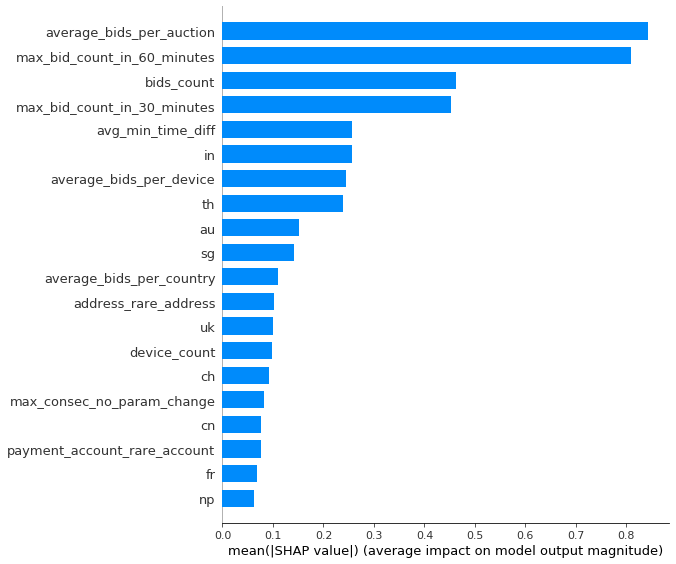

In [0]:
#SHAP
#, np.array(x_train, dtype=np.float64)
x_train.drop('outcome', axis=1, inplace=True)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type='bar')

Looks like the classifier gave high importance to more one-hot country columns than witout the SMOTE, probably due to them becoming non-binary after resampling.
This could imply that data cleaning after resampling is of certain value.

In [0]:
def shap_plot(S,model,j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [0]:
shap.initjs()
S = x_test[wrong]
shap_plot(S, xgbrf_model, 0)

NameError: ignored

In [0]:
#kernelExplainer
rf_shap_values = shap.KernelExplainer(rf.predict ,wrong_rf)

In [0]:
wrong_rf.astype('float64')

,payment_account_prefix_same_as_address_prefix,address_infrequent_address,address_rare_address,payment_account_infrequent_account,payment_account_rare_account,bids_count,auction_count,merchandise_count,device_count,country_count,ip_count,urls_count,average_bids_per_auction,average_bids_per_device,average_bids_per_url,average_bids_per_country,bids_per_auction_per_ip_mean,ip_only_one_user_counts,on_ip_that_has_a_bot,on_ip_that_has_a_bot_mean,on_device_that_has_a_bot,on_device_that_has_a_bot_mean,on_country_that_has_a_bot,on_country_that_has_a_bot_mean,on_url_that_has_a_bot,on_url_that_has_a_bot_mean,countries_per_bidder_per_auction_median,countries_per_bidder_per_auction_mean,countries_per_bidder_per_auction_max,ad,ae,af,ag,al,am,an,ao,ar,at,au,...,zz,wins,last_10%_auction_time_bids,first_10%_auction_time_bids,first_10%_bids_fraction,avg_min_time_diff,avg_max_time_diff,global_min_time_diff,global_max_time_diff,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,First_10%_time_bids_count_of_won_auctions,Last_90%_time_bids_count_of_won_auctions,Bids_count_of_won_auctions,First_10%_price_bids_count_of_won_auctions,Last_90%_price_bids_count_of_won_auctions,max_bid_count_in_10_minutes,max_bid_count_in_30_minutes,max_bid_count_in_60_minutes,max_consec_no_param_change,mean_consec_no_param_change,mean_country_change_time,mean_device_change_time,mean_ip_change_time,min_country_change_time,min_device_change_time,min_ip_change_time,percentage_of_bids_11_to_17,percentage_of_bids_17_to_23,percentage_of_bids_23_to_5,percentage_of_bids_5_to_11
306,0.0,0.0,1.0,0.0,1.0,329.0,97.0,1.0,87.0,40.0,289.0,11.0,3.391753,3.781609,29.909091,8.225000,1.031348,0.369732,1.0,0.290657,1.0,0.988506,1.0,1.000000,1.0,0.090909,1.0,1.505155,6.0,0.000000,0.010101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,...,0.000000,2.0,19.0,7.0,0.021277,1.388689e+11,2.980209e+11,0.0,4.151474e+12,7.0,220.0,7.0,2.0,1.0,2.0,47.0,24.0,0.0,17.0,2.0,0.0,6.0,8.0,0.0,3.0,45.0,117.0,191.0,0.0,0.000000,40.0,302.0,292.0,0.0,0.0,0.0,78.115502,21.884498,0.000000,0.000000
162,0.0,0.0,0.0,0.0,1.0,3057.0,365.0,1.0,147.0,83.0,1482.0,9.0,8.375342,20.795918,339.666667,36.831325,1.540050,0.360326,1.0,0.255061,1.0,0.986395,1.0,1.000000,1.0,0.111111,1.0,1.482192,35.0,0.000000,0.012579,0.048218,0.000000,0.006289,0.006289,0.000000,0.004193,0.041929,0.073375,0.041929,...,0.000000,15.0,629.0,942.0,0.308145,2.159752e+12,1.701177e+13,0.0,5.005232e+13,942.0,808.0,146.0,36.0,43.0,54.0,44.0,28.0,327.0,614.0,15.0,1.0,12.0,43.0,0.0,3.0,32.0,57.0,83.0,12.0,2.167630,374.0,368.0,324.0,0.0,0.0,0.0,15.865227,32.188420,29.506052,22.440301
861,0.0,0.0,1.0,0.0,1.0,5189.0,251.0,1.0,425.0,71.0,1494.0,1140.0,20.673307,12.209412,4.551754,73.084507,1.787461,0.103954,1.0,0.536145,1.0,0.960000,1.0,1.000000,1.0,0.383333,1.0,1.992032,15.0,0.000000,0.000504,0.000000,0.000000,0.001512,0.000000,0.000000,0.000000,0.000000,0.000504,0.000504,...,0.000000,5.0,712.0,697.0,0.134323,5.327437e+11,2.542263e+12,0.0,6.089474e+10,697.0,398.0,459.0,361.0,527.0,560.0,459.0,394.0,622.0,707.0,5.0,14.0,36.0,240.0,20.0,32.0,37.0,92.0,171.0,2.0,1.035533,67.0,53.0,55.0,0.0,0.0,0.0,26.498362,27.962999,21.796107,23.742532
137,0.0,0.0,1.0,0.0,1.0,7054.0,551.0,1.0,451.0,76.0,3887.0,4233.0,12.802178,15.640798,1.666430,92.815789,1.254937,0.357384,1.0,0.157448,1.0,0.977827,1.0,1.000000,1.0,0.000472,1.0,1.152450,31.0,0.000000,0.011289,0.000452,0.000000,0.000452,0.000000,0.000000,0.000000,0.003161,0.000000,0.006999,...,0.000000,19.0,1085.0,980.0,0.138928,8.566493e+11,3.367271e+12,0.0,2.684211e+10,980.0,511.0,754.0,591.0,559.0,799.0,676.0,437.0,662.0,1066.0,19.0,5.0,10.0,117.0,5.0,7.0,48.0,129.0,233.0,7.0,1.373626,65.0,38.0,37.0,0.0,0.0,0.0,22.937341,37.056989,15.055288,24.950383
8,0.0,0.0,1.0,0.0,0.0,923.0,55.0,1.0,124.0,1.0,915.0,1.0,16.781818,7.443548,923.000000,923.000000,1.001085,0.496454,0.0,0.000000,1.0,0.693548,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [0]:
shap.summary_plot(rf_shap_values.shap_values(wrong_rf.astype('float64')), wrong_rf.astype('float64'))

TypeError: ignored

# IMPORTANT FEATURES

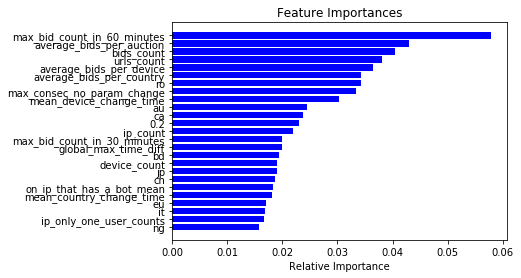

In [0]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)
features = x_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices[len(indices)-25:len(indices)])), importances[indices[len(indices)-25:len(indices)]], color='b', align='center')
plt.yticks(range(len(indices[len(indices)-25:len(indices)])), [features[i] for i in indices[len(indices)-25:len(indices)]])
plt.xlabel('Relative Importance')
plt.show()

In [0]:
important_features = features[indices[len(indices)-50:len(indices)]]

In [0]:
values = importances[indices[len(indices)-50:len(indices)]]
sum(values)

0.9288234054110944

In [0]:
xgb_error_features = (x_test[xgb_pred != y_test])[important_features]
xgb_error_features

,bids_per_auction_per_ip_mean,hk,qa,th,id,address_rare_address,de,0.4,sg,percentage_of_bids_17_to_23,tr,last_10%_auction_time_bids,no,be,average_bids_per_url,cz,percentage_of_bids_5_to_11,first_10%_auction_time_bids,in,ch,mean_consec_no_param_change,0.9,avg_max_time_diff,np,py,ng,ip_only_one_user_counts,it,eu,mean_country_change_time,on_ip_that_has_a_bot_mean,cn,jp,device_count,bd,global_max_time_diff,max_bid_count_in_30_minutes,ip_count,0.2,ca,au,mean_device_change_time,max_consec_no_param_change,ro,average_bids_per_country,average_bids_per_device,urls_count,bids_count,average_bids_per_auction,max_bid_count_in_60_minutes
306,1.031348,0.010101,0.010101,0.060606,0.010101,1,0.040404,2.0,0.030303,21.884498,0.030303,19.0,0.010101,0.000000,29.909091,0.000000,0.000000,7.0,0.060606,0.000000,0.000000,0.0,2.980209e+11,0.000000,0.000000,0.101010,0.369732,0.000000,0.000000,40.0,0.290657,0.000000,0.010101,87,0.000000,4.151474e+12,117.0,289,220.0,0.191919,0.000000,302.0,0.0,0.010101,8.225000,3.781609,11,329,3.391753,191.0
162,1.540050,0.023061,0.004193,0.111111,0.111111,0,0.180294,36.0,0.012579,32.188420,0.180294,629.0,0.002096,0.010482,339.666667,0.058700,22.440301,942.0,1.000000,0.056604,2.167630,327.0,1.701177e+13,0.008386,0.000000,0.144654,0.360326,0.238994,0.136268,374.0,0.255061,0.000000,0.000000,147,0.002096,5.005232e+13,57.0,1482,808.0,0.111111,0.041929,368.0,12.0,0.236897,36.831325,20.795918,9,3057,8.375342,83.0
861,1.787461,0.009073,0.001008,0.001008,0.573589,1,0.024194,361.0,0.000000,27.962999,0.022177,712.0,0.007560,0.000504,4.551754,0.000504,23.742532,697.0,0.256552,0.000000,1.035533,622.0,2.542263e+12,0.002016,0.000504,1.000000,0.103954,0.000000,0.005544,67.0,0.536145,0.003024,0.000000,425,0.004032,6.089474e+10,92.0,1494,398.0,0.016129,0.000504,53.0,2.0,0.000000,73.084507,12.209412,1140,5189,20.673307,171.0
137,1.254937,0.000000,0.008354,0.004967,0.047415,1,0.005193,591.0,0.001580,37.056989,0.049221,1085.0,0.000677,0.000000,1.666430,0.001355,24.950383,980.0,1.000000,0.000000,1.373626,662.0,3.367271e+12,0.000452,0.001806,0.006774,0.357384,0.005193,0.000452,65.0,0.157448,0.000000,0.000452,451,0.001129,2.684211e+10,129.0,3887,511.0,0.000452,0.006999,38.0,7.0,0.002484,92.815789,15.640798,4233,7054,12.802178,233.0
8,1.001085,0.000000,0.000000,0.000000,0.000000,1,0.000000,73.0,0.000000,0.000000,0.000000,74.0,0.000000,0.000000,923.000000,0.000000,55.796316,1.0,0.000000,0.000000,0.000000,383.0,2.572043e+12,0.000000,0.000000,0.000000,0.496454,0.000000,0.000000,1330.0,0.000000,0.000000,0.000000,124,0.000000,4.671684e+12,95.0,915,15.0,0.000000,0.000000,186.0,0.0,0.000000,923.000000,7.443548,1,923,16.781818,158.0
132,1.043646,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.089812,0.000000,60.885609,11.0,0.000000,0.351667,1.000000,0.0,2.890319e+12,0.000000,0.000000,0.000000,0.485117,0.000000,0.000000,34274.0,0.042362,0.000000,0.000000,3,0.000000,5.034947e+12,294.0,779,506.0,0.000000,0.000000,51411.0,1.0,0.000000,271.000000,271.000000,746,813,42.789474,449.0
1538,1.240482,0.015422,0.002537,0.041527,0.052876,1,0.305241,3415.0,0.030066,28.797357,0.027885,58164.0,0.006432,0.007233,716.526549,0.007789,22.630068,29186.0,0.698053,0.029487,1.022654,30521.0,1.214920e+13,0.002403,0.000601,0.000912,0.419912,0.030978,0.020430,6.0,0.041477,0.039012,0.019539,1144,0.002337,5.002111e+13,1141.0,111918,24227.0,0.021587,0.052231,5.0,2.0,0.018493,909.747191,141.551573,226,161935,194.867629,2231.0
1499,1.527871,0.000000,0.000000,0.000000,0.000000,0,0.000000,1.0,0.000000,30.417582,0.000000,434.0,0.000000,0.000000,3.013245,0.000000,17.450549,816.0,0.000000,0.000000,1.078947,205.0,2.469945e+13,0.000000,0.000000,0.000000,0.395911,0.000000,0.000000,1330.0,0.024259,0.000000,0.000000,249,0.000000,5.008768e+13,36.0,1484,804.0,0.000000,0.000000,426.0,3.0,0.000000,2275.000000,9.136546,755,2275,325.000000,62.0
378,2.016760,0.000000,0.000000,0.000000,0.953757,0,1.000000,19.0,0.005780,10.803324,0.011561,37.0,0.000000,0

In [0]:
bots_mean = bots_mean.transpose()
human_mean = human_mean.transpose()

In [0]:
bots_mean

address_infrequent_address               0.109589
address_rare_address                     0.616438
payment_account_infrequent_account       0.109589
payment_account_rare_account             0.410959
bids_count                            2899.054795
                                         ...     
percentage_of_bids_11_to_17             28.799723
percentage_of_bids_17_to_23             28.867940
percentage_of_bids_23_to_5              19.280964
percentage_of_bids_5_to_11              23.051374
outcome                                  1.000000
Name: mean, Length: 263, dtype: float64

In [0]:
important_bots_mean = bots_mean[important_features]
important_humans_mean = human_mean[important_features]

In [0]:
important_bots_mean.values

array([9.00807386e+00, 3.10481300e-03, 3.00550869e-03, 1.55905273e-01,
       2.57700600e-01, 6.16438356e-01, 5.06638766e-02, 1.49671233e+02,
       3.54142360e-02, 2.88679396e+01, 2.18356897e-02, 5.87958904e+02,
       1.28619534e-02, 3.92498506e-04, 1.27838761e+02, 1.72022458e-03,
       2.30513740e+01, 5.57726027e+02, 2.50649297e-01, 4.79773763e-03,
       3.85240371e+01, 3.60958904e+02, 7.17560920e+12, 2.92102312e-04,
       1.60611558e-03, 1.99272516e-02, 2.74400356e-01, 2.29760383e-02,
       1.55584813e-03, 6.90934247e+03, 3.24889249e-01, 2.34671130e-02,
       3.05618747e-02, 1.66136986e+02, 2.13658959e-03, 1.70360216e+13,
       9.79452055e+01, 1.59746575e+03, 3.71589041e+02, 3.95448839e-02,
       9.44472784e-02, 3.42142466e+03, 8.42054795e+01, 1.11106586e-03,
       1.72034211e+02, 1.18683542e+02, 5.79506849e+02, 2.89905479e+03,
       2.05134591e+01, 1.61534247e+02])

In [0]:
important_bots_mean

In [0]:
#histogram of bots vs humans
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        

def plot_histogram(names, bots_vals, humans_vals):
  x = np.arange(len(names))
  width = 0.8
  fig , ax = plt.subplots()
  rects1 = ax.barh(x - width/2, bots_vals.values.tolist(), width, label='Bots', align='center')
  rects2 = ax.barh(x + width/2, humans_vals.values.tolist(), width, label='Humans', align='center')
  fig.set_size_inches(15, 10)
  
  ax.set_ylabel('Scores')
  ax.set_title('Scores by group')
  ax.set_yticks(x)
  ax.set_yticklabels(names)
  ax.legend()



  autolabel(rects1)
  autolabel(rects2)
  fig.tight_layout()
  plt.show()
  return fig


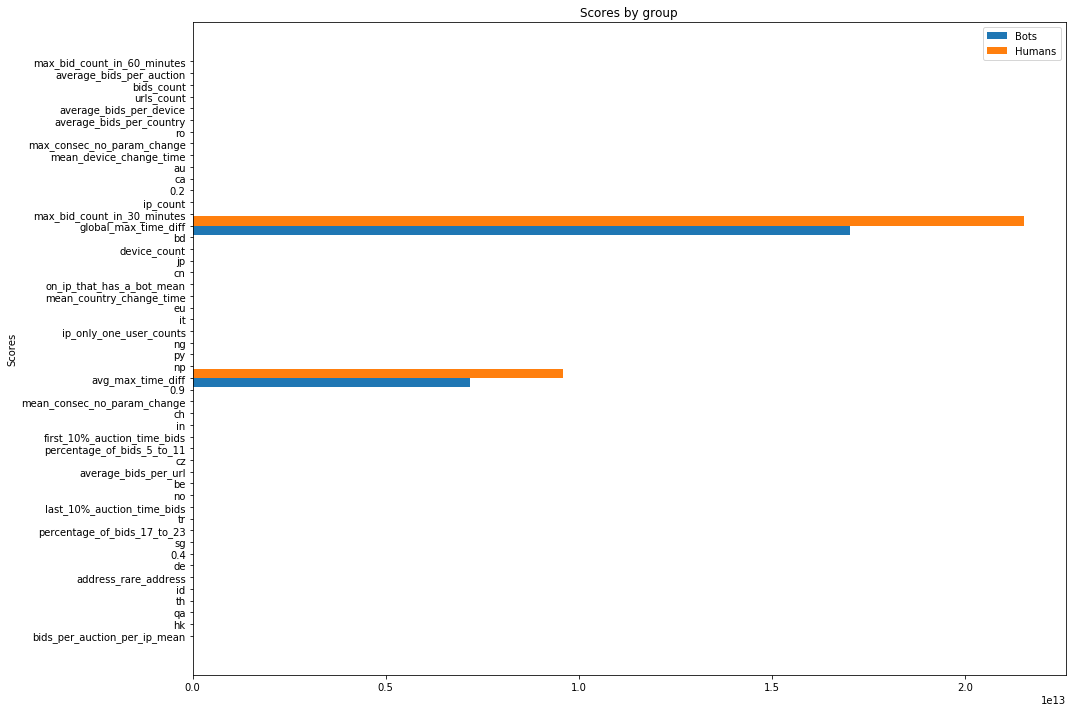

In [0]:
fig = plot_histogram(important_features, important_bots_mean, important_humans_mean)


In [0]:
l1 = [i for i in important_bots_mean.columns if i not in xgb_error_features.columns]
l2 = [i for i in xgb_error_features.columns if i not in important_bots_mean.columns]
print(l1)
print(l2)

[]
[]


In [0]:
normalized_bots_mean = important_bots_mean / np.linalg.norm(important_bots_mean)
normalized_humans_mean = important_humans_mean / np.linalg.norm(important_humans_mean)
normalized_xgb = (xgb_error_features.transpose() / np.linalg.norm(xgb_error_features, axis=1)).transpose()

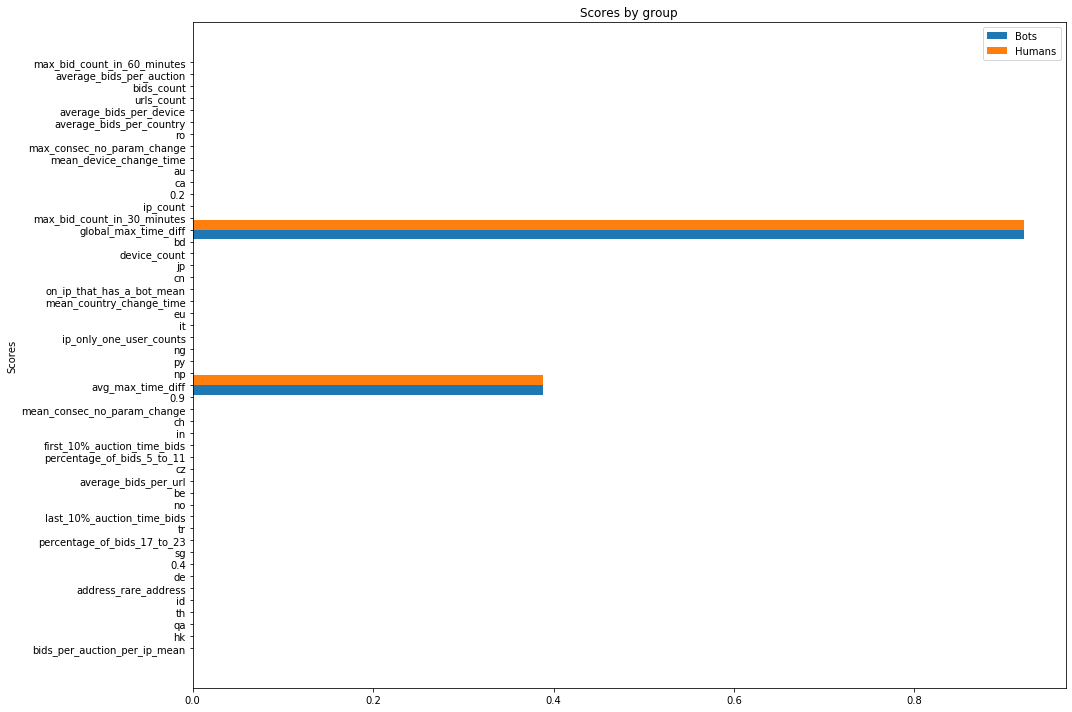

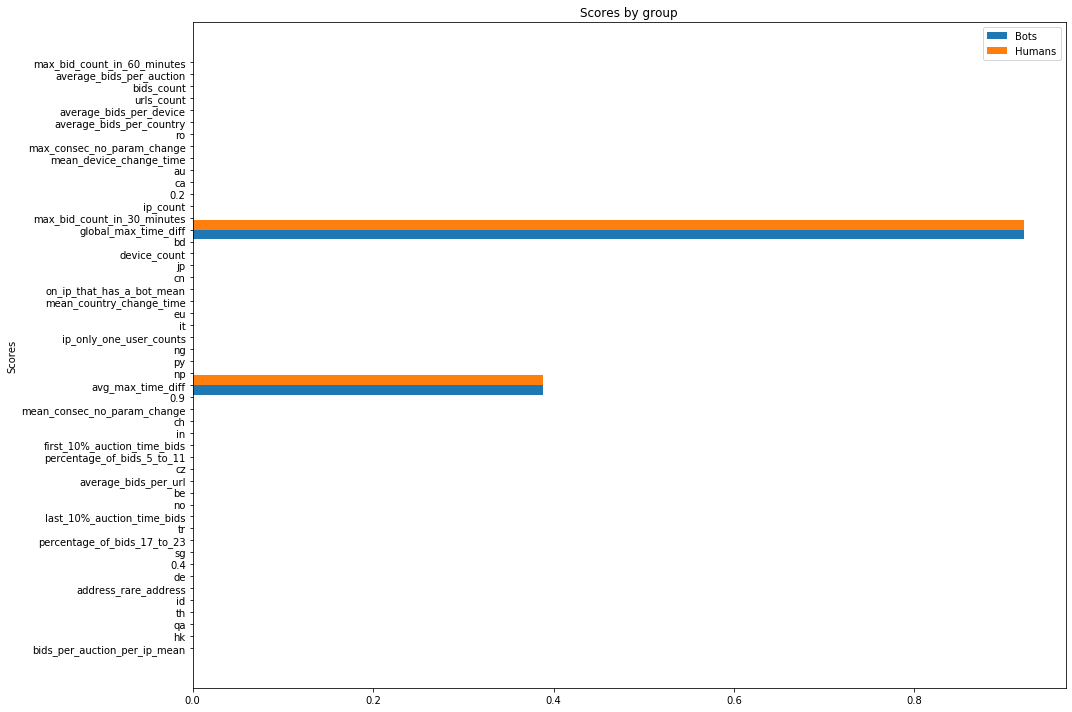

In [0]:
plot_histogram(important_features, normalized_bots_mean, normalized_bots_mean)

In [0]:
np.linalg.norm( normalized_xgb.values - normalized_bots_mean.values, axis=1)

array([0.32553086, 0.07100381, 1.08615733, 1.09953819, 0.10457591,
       0.12239513, 0.16020985, 0.05947369, 0.83271136, 1.05802231,
       1.07821564, 1.03194581, 0.87305526, 0.03850888, 0.03422908,
       0.03959127])

In [0]:
np.linalg.norm( normalized_xgb.values- normalized_humans_mean.values, axis=1)

array([0.34520077, 0.09093987, 1.06934979, 1.08281709, 0.08464582,
       0.10247426, 0.18008994, 0.03952737, 0.81452936, 1.04103795,
       1.06135753, 1.01480332, 0.85506102, 0.01855848, 0.01427812,
       0.05953757])

Nearest Neighbors of the bots that the model failed on



In [0]:
#K nearest neighbors
important_x_train = x_train[important_features]
knn = NearestNeighbors(n_neighbors=5, algorithm='brute').fit(important_x_train)
index_lst = knn.kneighbors(xgb_error_features, return_distance=False)
for i in index_lst:
  print(y_train.iloc[i])

1645    0.0
1500    0.0
1709    0.0
1398    0.0
1423    0.0
Name: outcome, dtype: float64
1517    1.0
1117    0.0
1788    0.0
444     0.0
7       0.0
Name: outcome, dtype: float64
1107    0.0
1760    0.0
1615    0.0
1177    0.0
1926    0.0
Name: outcome, dtype: float64
976     0.0
166     0.0
323     1.0
1272    0.0
1166    0.0
Name: outcome, dtype: float64
1439    0.0
119     0.0
1710    0.0
219     0.0
1933    0.0
Name: outcome, dtype: float64
627     0.0
1710    0.0
322     0.0
1439    0.0
39      0.0
Name: outcome, dtype: float64
1510    0.0
948     0.0
951     0.0
1682    0.0
121     0.0
Name: outcome, dtype: float64
1574    0.0
1654    0.0
243     0.0
1738    0.0
365     0.0
Name: outcome, dtype: float64
582     0.0
1454    0.0
1150    0.0
890     0.0
27      0.0
Name: outcome, dtype: float64
876     0.0
732     0.0
176     1.0
1089    0.0
1502    0.0
Name: outcome, dtype: float64
1926    0.0
234     0.0
1615    0.0
257     0.0
732     0.0
Name: outcome, dtype: float64
1199    0.